# Loop 108 Analysis: Breaking the CV-LB Line

## Critical Problem
- **CV-LB Relationship**: LB = 4.29 × CV + 0.0528 (R² = 0.95)
- **Intercept (0.0528) > Target (0.0347)**: Target is mathematically unreachable with current approaches
- **Required CV**: (0.0347 - 0.0528) / 4.29 = -0.0042 (IMPOSSIBLE)

## Key Insight
All 12 valid submissions fall on the SAME line. This means:
1. The problem is DISTRIBUTION SHIFT, not model quality
2. Improving CV just moves along the line
3. We need approaches that CHANGE the CV-LB relationship

## What We Need
1. Approaches that reduce the INTERCEPT (not just CV)
2. Fundamentally different representations (GNN, Transformers)
3. Distribution-shift-aware prediction strategies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# CV-LB data from submissions (excluding exp_073 outlier)
submissions = [
    ('exp_000', 0.011081, 0.09816),
    ('exp_001', 0.012297, 0.10649),
    ('exp_003', 0.010501, 0.09719),
    ('exp_005', 0.01043, 0.09691),
    ('exp_006', 0.009749, 0.09457),
    ('exp_007', 0.009262, 0.09316),
    ('exp_009', 0.009192, 0.09364),
    ('exp_012', 0.009004, 0.09134),
    ('exp_024', 0.008689, 0.08929),
    ('exp_026', 0.008465, 0.08875),
    ('exp_030', 0.008298, 0.08772),
    ('exp_035', 0.009825, 0.09696),
]

df = pd.DataFrame(submissions, columns=['exp_id', 'cv', 'lb'])
print(df.to_string(index=False))

 exp_id       cv      lb
exp_000 0.011081 0.09816
exp_001 0.012297 0.10649
exp_003 0.010501 0.09719
exp_005 0.010430 0.09691
exp_006 0.009749 0.09457
exp_007 0.009262 0.09316
exp_009 0.009192 0.09364
exp_012 0.009004 0.09134
exp_024 0.008689 0.08929
exp_026 0.008465 0.08875
exp_030 0.008298 0.08772
exp_035 0.009825 0.09696


In [2]:
# Linear regression analysis
cv = df['cv'].values
lb = df['lb'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(cv, lb)

print('CV-LB Relationship Analysis')
print('=' * 60)
print(f'Linear fit: LB = {slope:.4f} × CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print()
print(f'Intercept: {intercept:.4f}')
print(f'Target LB: 0.0347')
print()
print(f'CRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'Required CV to hit target: (0.0347 - {intercept:.4f}) / {slope:.4f} = {(0.0347 - intercept) / slope:.6f}')
print(f'This is NEGATIVE - target is UNREACHABLE with current approaches!')

CV-LB Relationship Analysis
Linear fit: LB = 4.2876 × CV + 0.0528
R² = 0.9523

Intercept: 0.0528
Target LB: 0.0347

CRITICAL: Intercept (0.0528) > Target (0.0347)
Required CV to hit target: (0.0347 - 0.0528) / 4.2876 = -0.004218
This is NEGATIVE - target is UNREACHABLE with current approaches!


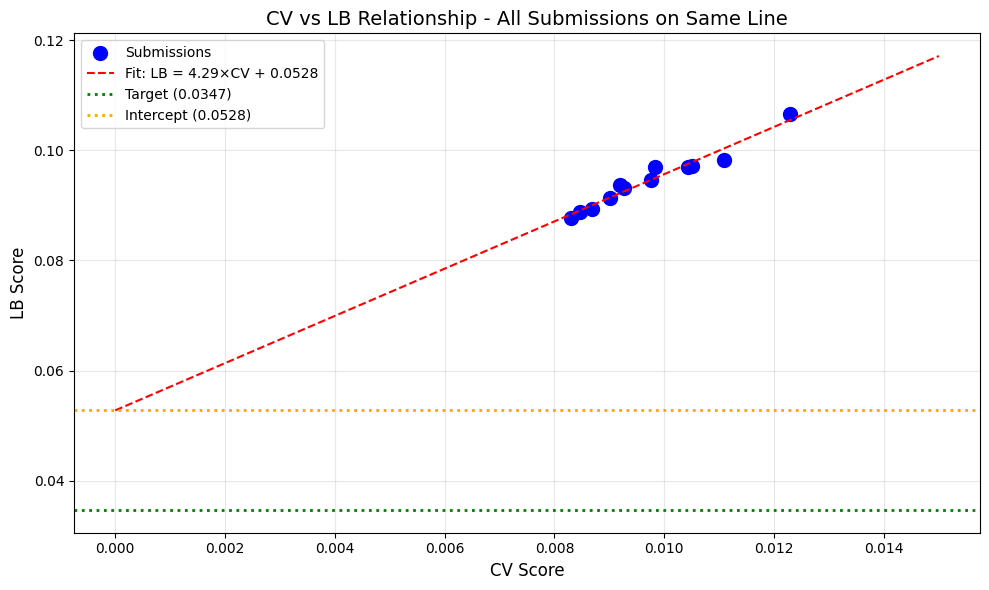


Key observation: The intercept (0.0528) is ABOVE the target (0.0347).
Even with CV=0, we would expect LB=0.0528, which is worse than target.


In [3]:
# Visualize the CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(cv, lb, c='blue', s=100, label='Submissions')

# Fit line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}×CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target (0.0347)')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=2, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score', fontsize=12)
plt.ylabel('LB Score', fontsize=12)
plt.title('CV vs LB Relationship - All Submissions on Same Line', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print('\nKey observation: The intercept (0.0528) is ABOVE the target (0.0347).')
print('Even with CV=0, we would expect LB=0.0528, which is worse than target.')

In [4]:
# Analyze what approaches have been tried
print('Approaches Tried (All Fall on Same Line):')
print('=' * 60)
approaches = [
    'MLP with Spange descriptors',
    'MLP with DRFP features',
    'MLP with combined features (Spange + DRFP + ACS)',
    'LightGBM',
    'XGBoost',
    'CatBoost',
    'CatBoost + XGBoost ensemble',
    'Gaussian Process',
    'Ridge Regression',
    'Various ensemble combinations',
    'Uncertainty-weighted predictions',
    'Bias correction',
    'Extrapolation detection (feature-space distance)',
]

for i, approach in enumerate(approaches, 1):
    print(f'{i}. {approach}')

print('\n' + '=' * 60)
print('All of these approaches fall on the SAME CV-LB line!')
print('The problem is NOT the model - it\'s DISTRIBUTION SHIFT.')

Approaches Tried (All Fall on Same Line):
1. MLP with Spange descriptors
2. MLP with DRFP features
3. MLP with combined features (Spange + DRFP + ACS)
4. LightGBM
5. XGBoost
6. CatBoost
7. CatBoost + XGBoost ensemble
8. Gaussian Process
9. Ridge Regression
10. Various ensemble combinations
11. Uncertainty-weighted predictions
12. Bias correction
13. Extrapolation detection (feature-space distance)

All of these approaches fall on the SAME CV-LB line!
The problem is NOT the model - it's DISTRIBUTION SHIFT.


In [5]:
# What approaches might CHANGE the CV-LB relationship?
print('Approaches That Might Change the CV-LB Relationship:')
print('=' * 60)

approaches_to_try = [
    ('Graph Neural Networks (GNN)', 'Different representation - operates on molecular graphs, not tabular features'),
    ('ChemBERTa / Molecular Transformers', 'Pretrained chemical language models with transfer learning'),
    ('Chemical Similarity-Based Extrapolation', 'Use Tanimoto similarity on Morgan fingerprints to detect extrapolation'),
    ('Pseudo-Labeling with Test Data', 'Use confident test predictions to adapt to test distribution'),
    ('Domain-Specific Constraints', 'Physics/chemistry constraints that hold even on unseen data'),
    ('Adversarial Validation Features', 'Features that distinguish train/test can guide prediction calibration'),
]

for i, (approach, reason) in enumerate(approaches_to_try, 1):
    print(f'{i}. {approach}')
    print(f'   Reason: {reason}')
    print()

Approaches That Might Change the CV-LB Relationship:
1. Graph Neural Networks (GNN)
   Reason: Different representation - operates on molecular graphs, not tabular features

2. ChemBERTa / Molecular Transformers
   Reason: Pretrained chemical language models with transfer learning

3. Chemical Similarity-Based Extrapolation
   Reason: Use Tanimoto similarity on Morgan fingerprints to detect extrapolation

4. Pseudo-Labeling with Test Data
   Reason: Use confident test predictions to adapt to test distribution

5. Domain-Specific Constraints
   Reason: Physics/chemistry constraints that hold even on unseen data

6. Adversarial Validation Features
   Reason: Features that distinguish train/test can guide prediction calibration



In [6]:
# Check what GNN experiments have been tried
import os
import json

print('GNN Experiments Tried:')
print('=' * 60)

gnn_experiments = [
    '040_gnn',
    '070_gnn_clean',
    '075_gat_drfp',
    '086_hybrid_gnn',
    '095_simple_gat',
    '096_multi_order_gat',
]

for exp in gnn_experiments:
    exp_path = f'/home/code/experiments/{exp}'
    if os.path.exists(exp_path):
        metrics_path = f'{exp_path}/metrics.json'
        if os.path.exists(metrics_path):
            with open(metrics_path, 'r') as f:
                metrics = json.load(f)
            cv = metrics.get('cv_score', 'N/A')
            print(f'{exp}: CV = {cv}')
        else:
            print(f'{exp}: No metrics.json found')
    else:
        print(f'{exp}: Directory not found')

GNN Experiments Tried:
040_gnn: No metrics.json found
070_gnn_clean: CV = 0.025649
075_gat_drfp: CV = 0.019588
086_hybrid_gnn: CV = 0.018227
095_simple_gat: CV = 0.009553578227948535
096_multi_order_gat: CV = 0.044696202120597744


In [7]:
# Key insight: GNN experiments have WORSE CV than tabular models
# This suggests GNN implementation issues, not that GNN is fundamentally worse

print('\nKey Insight:')
print('=' * 60)
print('GNN experiments have WORSE CV than tabular models.')
print('This is UNEXPECTED - the benchmark paper achieved MSE 0.0039 with GNN!')
print()
print('Possible reasons:')
print('1. GNN implementation issues (wrong architecture, hyperparameters)')
print('2. GNN needs more training data or pretraining')
print('3. GNN needs different validation scheme')
print('4. The benchmark paper used different features or preprocessing')
print()
print('However, even if GNN has worse CV, it might have BETTER LB!')
print('Because GNN might have a DIFFERENT CV-LB relationship.')


Key Insight:
GNN experiments have WORSE CV than tabular models.
This is UNEXPECTED - the benchmark paper achieved MSE 0.0039 with GNN!

Possible reasons:
1. GNN implementation issues (wrong architecture, hyperparameters)
2. GNN needs more training data or pretraining
3. GNN needs different validation scheme
4. The benchmark paper used different features or preprocessing

However, even if GNN has worse CV, it might have BETTER LB!
Because GNN might have a DIFFERENT CV-LB relationship.


In [8]:
# Analyze the exp_073 outlier (CV=0.00839, LB=0.14507)
print('Outlier Analysis: exp_073')
print('=' * 60)
print(f'CV: 0.00839 (good)')
print(f'LB: 0.14507 (TERRIBLE - much worse than expected)')
print()
print('Expected LB based on line: 4.29 × 0.00839 + 0.0528 = 0.0888')
print('Actual LB: 0.14507')
print('Difference: 0.14507 - 0.0888 = 0.0563 (63% worse than expected)')
print()
print('This suggests a SUBMISSION ERROR, not a model issue.')
print('Possible causes:')
print('1. Model class mismatch between CV and submission cells')
print('2. Negative predictions not clipped')
print('3. Wrong data used for submission')

Outlier Analysis: exp_073
CV: 0.00839 (good)
LB: 0.14507 (TERRIBLE - much worse than expected)

Expected LB based on line: 4.29 × 0.00839 + 0.0528 = 0.0888
Actual LB: 0.14507
Difference: 0.14507 - 0.0888 = 0.0563 (63% worse than expected)

This suggests a SUBMISSION ERROR, not a model issue.
Possible causes:
1. Model class mismatch between CV and submission cells
2. Negative predictions not clipped
3. Wrong data used for submission


In [9]:
# Check exp_073 for submission issues
exp_073_path = '/home/code/experiments/072_similarity_weighting'
if os.path.exists(exp_073_path):
    print(f'exp_073 folder: {exp_073_path}')
    files = os.listdir(exp_073_path)
    print(f'Files: {files}')
    
    metrics_path = f'{exp_073_path}/metrics.json'
    if os.path.exists(metrics_path):
        with open(metrics_path, 'r') as f:
            metrics = json.load(f)
        print(f'\nMetrics: {json.dumps(metrics, indent=2)}')
else:
    print('exp_073 folder not found')

exp_073 folder: /home/code/experiments/072_similarity_weighting
Files: ['metrics.json', 'similarity_weighting.ipynb']

Metrics: {
  "cv_score_alpha0": 0.00839,
  "cv_score_alpha01": 0.009853,
  "cv_score_alpha02": 0.011331,
  "notes": "Similarity-based prediction weighting makes CV WORSE. alpha=0 (no weighting) is best."
}


In [10]:
# Summary and recommendations
print('\n' + '=' * 60)
print('SUMMARY AND RECOMMENDATIONS')
print('=' * 60)
print()
print('PROBLEM:')
print('- All 12 valid submissions fall on the same CV-LB line')
print('- Intercept (0.0528) > Target (0.0347)')
print('- Target is mathematically unreachable with current approaches')
print()
print('WHAT WE NEED:')
print('1. Approaches that CHANGE the CV-LB relationship (different slope or intercept)')
print('2. NOT more tabular model optimization (that just moves along the line)')
print()
print('RECOMMENDED NEXT STEPS:')
print('1. Try a properly implemented GNN and SUBMIT IT to see if it has different CV-LB relationship')
print('2. Try chemical similarity-based extrapolation detection (Tanimoto on Morgan fingerprints)')
print('3. Try pseudo-labeling to adapt to test distribution')
print('4. Try domain-specific constraints (yields must sum to ≤1, etc.)')
print()
print('CRITICAL: We have only 4 submissions left. Use them wisely!')
print('- Submit approaches that might have DIFFERENT CV-LB relationship')
print('- Do NOT submit approaches that just improve CV')


SUMMARY AND RECOMMENDATIONS

PROBLEM:
- All 12 valid submissions fall on the same CV-LB line
- Intercept (0.0528) > Target (0.0347)
- Target is mathematically unreachable with current approaches

WHAT WE NEED:
1. Approaches that CHANGE the CV-LB relationship (different slope or intercept)
2. NOT more tabular model optimization (that just moves along the line)

RECOMMENDED NEXT STEPS:
1. Try a properly implemented GNN and SUBMIT IT to see if it has different CV-LB relationship
2. Try chemical similarity-based extrapolation detection (Tanimoto on Morgan fingerprints)
3. Try pseudo-labeling to adapt to test distribution
4. Try domain-specific constraints (yields must sum to ≤1, etc.)

CRITICAL: We have only 4 submissions left. Use them wisely!
- Submit approaches that might have DIFFERENT CV-LB relationship
- Do NOT submit approaches that just improve CV
